<a href="https://colab.research.google.com/github/ThrupthiAnn/SummerSchool2021_HandsOn_Aug7/blob/main/CNN/4_ResNet_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Residual Networks [1]
In this tutorial we will implement a resnet block and use it as one of the block for training a CNN on CIFAR dataset. The residual module is shown below:-

![resnet](https://github.com/ckraju/summer/blob/main/data/resnet/resnet.png?raw=1)

In [ ]:
# Import all libraries
import os
import argparse
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Data loader
train_loader = torch.utils.data.DataLoader(
	datasets.CIFAR10('../../data/lab1/imgFolders', train=True, download=True,
		transform=transforms.ToTensor()),
	batch_size=4, shuffle=True)

test_loader = torch.utils.data.DataLoader(
	datasets.CIFAR10('../../data/lab1/imgFolders', train=False, download=False,
		transform=transforms.ToTensor()),
	batch_size=4, shuffle=False)

num_epoch = 5

Files already downloaded and verified


#### Basic ResNet Module

In [ ]:
#Definition of basic residual block which would be replicated
class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        #batch normalization
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        #adding the skip connection
        out += residual
        out = self.relu(out)

        return out


### Defining the CNN architecture using ResNet modules

In [ ]:
#Defining the entire CNN architecture using multiple resnet modules
class ResNet(nn.Module):
    
    def __init__(self, block, layers, num_classes=10):
        self.input_channels = 64
        super(ResNet, self).__init__()
        
        #Initial non-resnet layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,bias=False) # input ch = 3, output ch = 64 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #Creating the resnet modules
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.fc = nn.Linear(4096, num_classes)
    
    #Duplicating the resnet module
    def _make_layer(self, block, target_output_channels, blocks, stride=1):
        layers = []
        self.input_channels = target_output_channels
        for i in range(0, blocks):
            layers.append(block(self.input_channels, target_output_channels))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        #attaching the resnet modules
        x = self.layer1(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x



In [ ]:
model = ResNet(BasicBlock, [2]).cuda()
print(model)
criterion = nn.CrossEntropyLoss()

#Using adam optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training

In [ ]:
plotIter = 2000
plotIterCntr = 0
numEpochs = 1
trainLoss = np.zeros((plotIter*numEpochs,1))
trainIter = np.arange(plotIter*numEpochs)



In [ ]:
for epoch in range(numEpochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data
        if i % plotIter == plotIter-1:    # print every plotIter mini-batches
            temp = running_loss / plotIter
            trainLoss[plotIterCntr] = temp.cpu()
            plotIterCntr+=1
            
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / plotIter))
            running_loss = 0.0
            


[1,  2000] loss: 1.228
[1,  4000] loss: 1.154
[1,  6000] loss: 1.106
[1,  8000] loss: 1.089
[1, 10000] loss: 1.067
[1, 12000] loss: 1.054


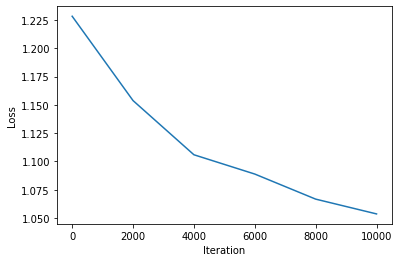

Finished Training


In [ ]:
plt.plot(np.arange(plotIterCntr)*plotIter,trainLoss[0:plotIterCntr], label="train")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

print('Finished Training')

#### Testing

In [ ]:
## Prediction of accuracy
correct = 0
total = 0

for data in test_loader:
    images, labels = data
    outputs = model(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    labels = labels.cuda()
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 65 %


### Self Exercise
- Add multiple resnet modules and verify the performance in CIFAR dataset
- Create a bottleneck based ResNet module as shown below and validate the training performance:-
![resnet-bottleneck](https://github.com/ckraju/summer/blob/main/images/resnet-bottleneck.png?raw=1)

### References
[1] He et. al., Deep Residual Learning for Image Recognition, arxiv’15 <br>